In [1]:
import sys
print(sys.executable)   # path to the Python interpreter being used
print(sys.version)      # Python version

/BS/dnn_interpretablity_robustness_representation_learning_2/work/libs/miniforge3/envs/python310_pytorch_simple/bin/python
3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


In [2]:
"""
This notebook demonstrates a simplified implementation of the original R-CNN method for object detection using COCO-style data. 
Each step is visualized and annotated for better conceptual understanding.

Paper: Rich feature hierarchies for accurate object detection and semantic segmentation
Link: https://arxiv.org/abs/1311.2524
"""

'\nThis notebook demonstrates a simplified implementation of the original R-CNN method for object detection using COCO-style data. \nEach step is visualized and annotated for better conceptual understanding.\n\nPaper: Rich feature hierarchies for accurate object detection and semantic segmentation\nLink: https://arxiv.org/abs/1311.2524\n'

In [3]:
# Setup and configuration
import torch
import torchvision
import torchvision.transforms as T

import numpy as np
import cv2
import os
from PIL import Image
from tqdm import tqdm

from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [12]:
# Config
IMAGE_SIZE = 227
PAD_PIXELS = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
COCO_ROOT = "/BS/generative_modelling_for_image_understanding/nobackup/data/DETECTRON2_DATASETS/coco"
COCO_SPLIT = "val2017"
N_CLASSES = 80
N_NEG_PER_IMAGE = 20

In [14]:
# Create a mapping from COCO category_id to contiguous 0-indexed class IDs
cat_ids = coco.getCatIds()
cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}
N_CLASSES = len(cat_ids)  # override to actual class count

In [5]:
# load CNN model with related transforms
cnn = torchvision.models.alexnet(pretrained=True).to(DEVICE)
cnn.eval()
feature_extractor = torch.nn.Sequential(*list(cnn.children())[:-1])

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/BS/dnn_interpretablity_robustness_representation_learning_2/work/libs/miniforge3/envs/python310_pytorch_simple/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/BS/dnn_interpretablity_robustness_representation_learning_2/work/libs/miniforge3/envs/python310_pytorch_simple/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Get and visualize selective search proposals
def get_region_proposals(img):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects[:2000]  # top-N proposals

def show_proposals(img_pil, rects, num=10):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_pil)
    for i, (x, y, w, h) in enumerate(rects[:num]):
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title("Top Region Proposals")
    plt.axis('off')
    plt.show()

In [7]:
# Feature Extraction
def extract_features_from_box(image_pil, box):
    x, y, w, h = box
    img_w, img_h = image_pil.size
    
    # Expand box by PAD_PIXELS in all directions
    x1 = max(x - PAD_PIXELS, 0)
    y1 = max(y - PAD_PIXELS, 0)
    x2 = min(x + w + PAD_PIXELS, img_w)
    y2 = min(y + h + PAD_PIXELS, img_h)

    crop = image_pil.crop((x1, y1, x2, y2))
    resized = transform(crop).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        features = feature_extractor(resized).view(-1).cpu().numpy()
    return features

In [10]:
# helper functions
def compute_iou_xywh(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / float(boxAArea + boxBArea - interArea)

In [8]:
# load coco data
coco = COCO(os.path.join(COCO_ROOT, "annotations", f"instances_{COCO_SPLIT}.json"))
image_ids = coco.getImgIds()
image_dir = os.path.join(COCO_ROOT, COCO_SPLIT)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


  0%|                                                                                                   | 0/5 [00:00<?, ?it/s]

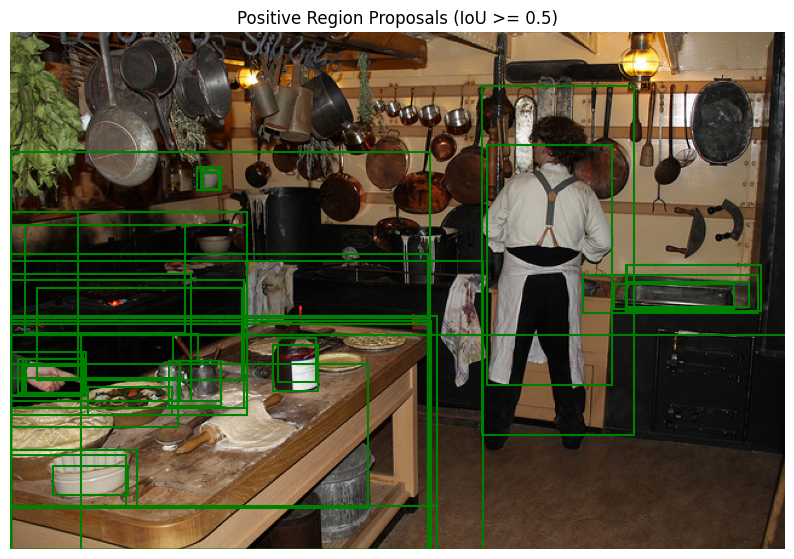

 20%|██████████████████▏                                                                        | 1/5 [00:22<01:29, 22.45s/it]

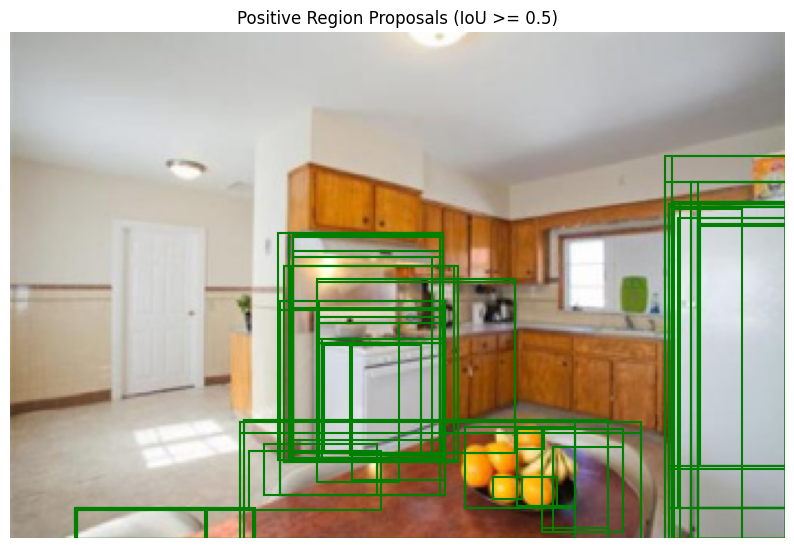

 40%|████████████████████████████████████▍                                                      | 2/5 [00:31<00:44, 14.78s/it]

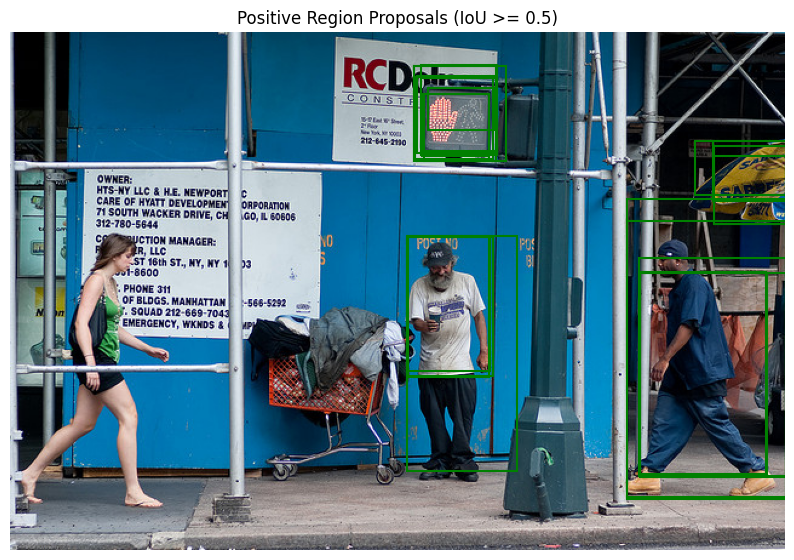

 60%|██████████████████████████████████████████████████████▌                                    | 3/5 [00:55<00:37, 18.79s/it]

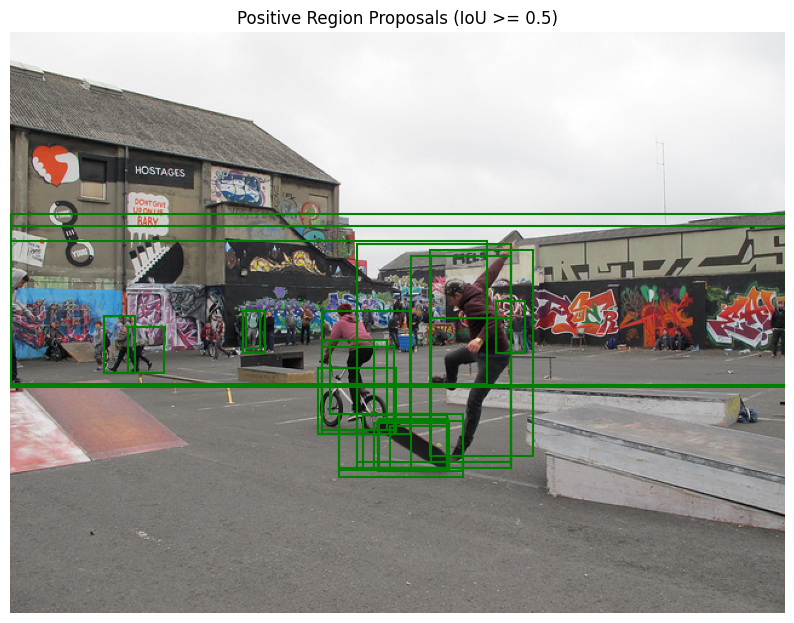

 80%|████████████████████████████████████████████████████████████████████████▊                  | 4/5 [01:18<00:20, 20.33s/it]

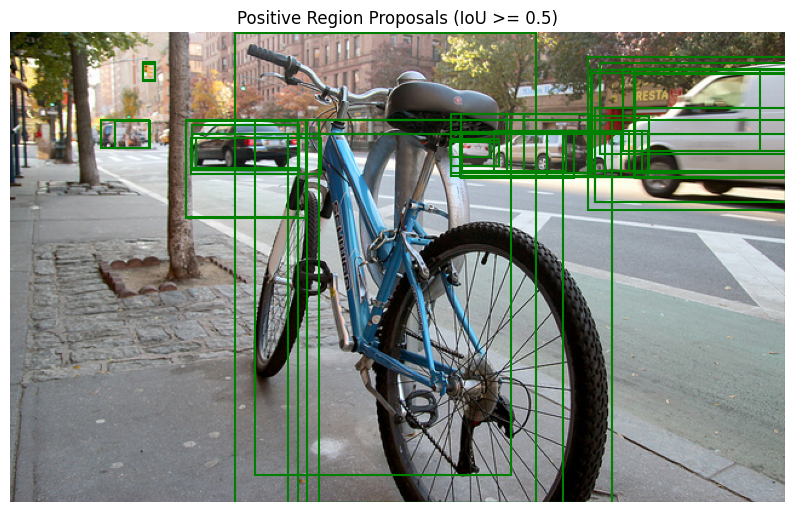

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:41<00:00, 20.37s/it]


In [19]:
# main loop with vizualizations
feature_list = [[] for _ in range(N_CLASSES)]
label_list = [[] for _ in range(N_CLASSES)]
bbox_targets = [{} for _ in range(N_CLASSES)]

cat_ids = coco.getCatIds()
cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}
N_CLASSES = len(cat_ids)

for img_id in tqdm(image_ids[:5]):  # limit for demo
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(image_dir, img_info['file_name'])
    img_pil = Image.open(img_path).convert("RGB")
    img_cv = np.array(img_pil)[:, :, ::-1]

    gt_anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    gt_boxes = [ann['bbox'] for ann in gt_anns]
    gt_classes = [ann['category_id'] for ann in gt_anns]

    region_props = get_region_proposals(img_cv)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_pil)

    for box in region_props:
        x, y, w, h = box
        ious = [compute_iou_xywh(box, gt_box) for gt_box in gt_boxes]
        if not ious: continue

        max_iou = max(ious)
        max_idx = np.argmax(ious)
        gt_class_id = gt_classes[max_idx]
        if gt_class_id not in cat_id_to_idx:
            continue
        max_class = cat_id_to_idx[gt_class_id]
        gt_box = gt_boxes[max_idx]

        feat = extract_features_from_box(img_pil, box)

        if max_iou >= 0.5:
            feature_list[max_class].append(feat)
            label_list[max_class].append(1)

            rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

            # BBox regression targets
            px, py, pw, ph = x + w / 2, y + h / 2, w, h
            gx, gy, gw, gh = gt_box[0] + gt_box[2] / 2, gt_box[1] + gt_box[3] / 2, gt_box[2], gt_box[3]
            dx = (gx - px) / pw
            dy = (gy - py) / ph
            dw = np.log(gw / pw)
            dh = np.log(gh / ph)
            for key, val in zip(["dx", "dy", "dw", "dh"], [dx, dy, dw, dh]):
                bbox_targets[max_class].setdefault(key, []).append(val)

        elif max_iou < 0.3 and len(label_list[max_class]) < N_NEG_PER_IMAGE:
            feature_list[max_class].append(feat)
            label_list[max_class].append(0)

    plt.title("Positive Region Proposals (IoU >= 0.5)")
    plt.axis('off')
    plt.show()

In [21]:
# Train SVMs + BBox Regressors
svms = []
bbox_regressors = []

for c in range(N_CLASSES):
    if len(label_list[c]) == 0:
        svms.append(None)
        bbox_regressors.append(None)
        continue
    X = np.stack(feature_list[c])
    y = np.array(label_list[c])
    svm = LinearSVC(C=1.0, max_iter=1000)
    svm.fit(X, y)
    svms.append(svm)

    if "dx" in bbox_targets[c]:
        bbox_regs = {}
        for key in ["dx", "dy", "dw", "dh"]:
            reg = Ridge(alpha=1000.0)
            reg.fit(X[y == 1], np.array(bbox_targets[c][key]))
            bbox_regs[key] = reg
        bbox_regressors.append(bbox_regs)
    else:
        bbox_regressors.append(None)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [17]:
region_props[:10]

array([[364, 359,  17,  29],
       [ 55, 206,  65,  27],
       [260, 189,  23,  75],
       [243,   0, 270, 118],
       [409,  42,  16,  15],
       [290, 279,  33,  37],
       [ 38, 182,  33,   8],
       [341, 149,  24,  20],
       [528,  57,  30,  15],
       [262, 201,  21,  57]], dtype=int32)

In [18]:
bbox_targets

[{'dx': [np.float64(-0.10250000000000004),
   np.float64(-0.0866666666666667),
   np.float64(-0.08239837398373977),
   np.float64(-0.13840000000000002),
   np.float64(-0.12333333333333336),
   np.float64(-0.08339622641509437),
   np.float64(0.009508196721311448),
   np.float64(-0.04400000000000003),
   np.float64(-0.12333333333333336),
   np.float64(-0.031336206896551644),
   np.float64(0.01799999999999997),
   np.float64(-0.05975206611570263),
   np.float64(-0.05975206611570263),
   np.float64(-0.03297872340425556),
   np.float64(-0.16401960784313743),
   np.float64(0.005633802816901088),
   np.float64(0.07064516129032251),
   np.float64(0.0025961538461536714),
   np.float64(-0.008450704225352433),
   np.float64(0.041975308641975025),
   np.float64(0.005797101449275033),
   np.float64(-0.06441666666666682),
   np.float64(0.028484848484848415),
   np.float64(-0.14408163265306126),
   np.float64(-0.019722222222223234),
   np.float64(0.2549606299212598),
   np.float64(-0.0760919540229885